[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nrao/astrohack/blob/v0.9.3/docs/tutorial_vla.ipynb)

![astrohack](_media/astrohack_logo.png)

# VLA Holography Tutorial

### Important External Information

- #### xarray Official Documentation ([docs](https://docs.xarray.dev/en/stable/)).
- #### Dask Official Documentation ([docs](https://www.dask.org/)).
- #### zarr Official Documentation ([docs](https://zarr.readthedocs.io/en/stable/))

In [1]:
import os

try:
    import astrohack

    print("AstroHACK version", astrohack.__version__, "already installed.")
except ImportError as e:
    print(e)
    print("Installing AstroHACK")

    os.system("pip install astrohack")

    import astrohack

    print("astrohack version", astrohack.__version__, " installed.")

AstroHACK version 0.9.3 already installed.


## Download Tutorial Data

In [2]:
import toolviper

toolviper.utils.data.download(file="ea25_cal_small_after_fixed.split.ms", folder="data")

[2025-10-29 14:58:17,266]     INFO   astrohack:  Module path: /home/victor/mambaforge/envs/casadev/lib/python3.12/site-packages/toolviper 


[2025-10-29 14:58:17,272]     INFO   astrohack:  Downloading from [cloudflare] .... 


 Download List                        
 ───────────────────────────────────── 
  ea25_cal_small_after_fixed.split.ms

[2025-10-29 14:58:17,277]     INFO   astrohack:  Creating path:/home/victor/work/Holography-1022/astrohack/docs/data 


Output()

## Holography Data File API

As part of the `astroHACK` API a set of functions to allow users to easily open on disk holography files has been provided. Each function takes an `astroHACK` holography file name as an argument and returns an object related to the given file type, ie. holog, image, panel, point. Each object allows the user to access data via dictionary keys with values consisting of the relevant holography dataset. Each object also provides a `summary()` helper function to list available keys for each file. An example call for each file type is show below and the API documentation for all data-io functions can be found [here](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/dio/index.html).

```python
from astrohack.dio import open_holog
from astrohack.dio import open_image
from astrohack.dio import open_panel
from astrohack.dio import open_pointing

holog_data = open_holog(file='./data/ea25_cal_small_spw1_4_60_ea04_after.holog.zarr')
image_data = open_image(file='./data/ea25_cal_small_spw1_4_60_ea04_after.image.zarr')
panel_data = open_panel(file='./data/ea25_cal_small_spw1_4_60_ea04_after.panel.zarr')
pointing_data = open_pointing(file='./data/ea25_cal_small_spw1_4_60_ea04_after.point.zarr')
```

## Setup Dask Local Cluster

The local Dask client handles scheduling and worker managment for the parallelization. The user has the option of choosing the number of cores and memory allocations for each worker howerver, we recommend a minimum of 8Gb per core with standard settings.


A significant amount of information related to the client and scheduling can be found using the [Dask Dashboard](https://docs.dask.org/en/stable/dashboard.html). This is a built in dashboard native to Dask and allows the user to monitor the workers during processing. This is especially useful for profilling. For those that are interested in working soley within Jupyterlab a dashboard extension is availabe for [Jupyterlab](https://github.com/dask/dask-labextension#dask-jupyterlab-extension).

![dashboard](_media/dashboard.png)

## Estimating Memory Requirements
A new functionality, currently being refined, is a function to estimate the amount of memory per core max that would be required to process a given file. The estimation is given as the suggested memory per core need to not spilling over into swap memory. If the user has already computed the holog_obs_dict, it can be added as a parameter to speed up the estitmate as this is a serial function currently.

In the resulting table the following definitions are important:

- **Available memory**: The available memory on the system currently, ie. the total not currently in use.
- **Total memory**: The total system memory
- **Suggested memory per core**: Memory allocation per core estimated to not spill ove rinto swap memory.

  Reference: *https://psutil.readthedocs.io/en/latest/#psutil.virtual_memory*

In [3]:
from astrohack.extract_holog import model_memory_usage

# the elastic model download needs to be fixed
#model_memory_usage(
#    ms_name="data/ea25_cal_small_after_fixed.split.ms",
#    holog_obs_dict=None
#)


In [4]:
from toolviper.dask import menrva
from toolviper.dask.client import local_client

client = local_client(cores=4, memory_limit="1GB")
client

[2025-10-29 14:58:35,185]     INFO   astrohack:  Module path: /home/victor/mambaforge/envs/casadev/lib/python3.12/site-packages/toolviper 


[2025-10-29 14:58:35,190]  WARNING   astrohack:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 


[2025-10-29 14:58:36,634]     INFO   astrohack:  Client <MenrvaClient: 'tcp://127.0.0.1:35405' processes=4 threads=4, memory=3.73 GiB> 


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35405,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:46267,Total threads: 1
Dashboard: http://127.0.0.1:45417/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:33557,


### Holography processing
## Extract Holog

The extraction and restructuring of the holography data is done using the `extract_holog` function. This function is similar in function to the `UVHOL` task in AIPS. 
The holography data that is extracted can be set using the compound dictionary *holog_obs_description*: *mapping*, *scan*, and *antenna* id. A detailed description of the structure of the *holog_obs_description* dictionary can be found in the documentation [here](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/extract_holog/index.html). The `extract_holog` can automatically generate the *holog_obs_description* by inspecting the pointing table. 

Inline information on the input parameters can also be gotten using `help(extract_holog)` in the cell.

In [5]:
from astrohack.extract_pointing import extract_pointing
from astrohack.extract_holog import extract_holog

extract_pointing(
    ms_name="data/ea25_cal_small_after_fixed.split.ms",
    point_name="data/ea25_cal_small_after_fixed.split.point.zarr",
    parallel=True,
    overwrite=True,
)

holog_mds = extract_holog(
    ms_name="data/ea25_cal_small_after_fixed.split.ms",
    point_name="data/ea25_cal_small_after_fixed.split.point.zarr",
    data_column="CORRECTED_DATA",
    parallel=True,
    overwrite=True,
)

[2025-10-29 14:58:36,665]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


[2025-10-29 14:58:43,908]     INFO   astrohack:  Finished processing 


[2025-10-29 14:58:43,944]     INFO   astrohack:  Creating output file name: data/ea25_cal_small_after_fixed.split.holog.zarr 


[2025-10-29 14:58:43,970]     INFO   astrohack:  Processing ddi: 0, scans: [8 ... 57] 


[2025-10-29 14:58:43,972]     INFO   astrohack:  Processing ddi: 1, scans: [8 ... 57] 


[2025-10-29 14:58:55,652]     INFO    worker_3:  EA06: DDI 1: Suggested cell size 2.20 amin, FOV: (1.11 deg, 1.11 deg) 
[2025-10-29 14:58:55,654]     INFO    worker_3:  EA25: DDI 1: Suggested cell size 2.20 amin, FOV: (1.11 deg, 1.11 deg) 


2025-10-29 14:58:57,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 671.56 MiB -- Worker memory limit: 0.93 GiB


[2025-10-29 14:58:57,601]     INFO    worker_3:  Finished extracting holography chunk for ddi: 1 holog_map_key: map_0 


[2025-10-29 14:58:57,807]     INFO    worker_0:  EA06: DDI 0: Suggested cell size 2.47 amin, FOV: (1.11 deg, 1.11 deg) 
[2025-10-29 14:58:57,810]     INFO    worker_0:  EA25: DDI 0: Suggested cell size 2.47 amin, FOV: (1.11 deg, 1.11 deg) 


2025-10-29 14:58:58,889 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 668.68 MiB -- Worker memory limit: 0.93 GiB


[2025-10-29 14:58:59,753]     INFO    worker_0:  Finished extracting holography chunk for ddi: 0 holog_map_key: map_0 
[2025-10-29 14:58:59,771]     INFO   astrohack:  Finished processing 


Two files are created by `extract_holog`: The extracted pointing information in the form of `<point_name>.point.zarr` and the extracted holography data as `<point_name>.holog.zarr`. In addition, a holography data object is returned. This is the same holography data object returned by the hologrphy data API above. The `holog_mds` object is a python dict containing the extracted holography data found in `.holog.zarr` but with extended functionality such as providing a summary of the run infomation in table form. Below for each `DDI` we can see the available `scan` and `antenna` information.


___point_name.point.zarr:___ <span style="color:red"> The pointing zarr file contains position and pointing information extracted from the pointing table of the input measurement set. In addition, the antenna and mapping scan information is listed for each antenna. The pointing object is structured as a simple dictionary with `key:value` sets with the key being the antenna id and the value being the pointing dataset. </span>

```
point_mds = 
{
   ant_0: point_ds,
            ⋮
   ant_n: point_ds
}
```


___holog_name.holog.zarr:___ <span style="color:red"> The holog zarr file contains ungridded data extracted from the pointing and main tables in the measurement set. The holog file includes the directional, visibility and weight information recorded on a shared time axis; the sampling is done because the native sample rates between the pointing and main tables are not the same. In addition, the meta data such as sampled parallactic data (beginning, middle and end of scan) and l(m) extent is recorded in the file attributes. The holog file structure is a compound dictionary keyed according to `ddi` -> `map` -> `ant` with values consisting of the holog dataset. </span>

```
holog_mds = 
{
   ddi_0:{
          map_0:{
                 ant_0: holog_ds,
                          ⋮
                 ant_n: holog_ds
                },
              ⋮
          map_p: …
         },
       ⋮
   ddi_m: …
}

```

An example of the holog dataset object is show below.

In [6]:
holog_mds["ddi_0"]["map_0"]["ant_ea25"]

<xarray.Dataset> Size: 55MB
Dimensions:                    (time: 8914, lm: 2, chan: 64, pol: 4)
Coordinates:
  * chan                       (chan) float64 512B 1.41e+10 ... 1.423e+10
  * pol                        (pol) <U2 32B 'RR' 'RL' 'LR' 'LL'
  * time                       (time) float64 71kB 5.17e+09 ... 5.17e+09
Dimensions without coordinates: lm
Data variables:
    DIRECTIONAL_COSINES        (time, lm) float64 143kB dask.array<chunksize=(8914, 2), meta=np.ndarray>
    IDEAL_DIRECTIONAL_COSINES  (time, lm) float64 143kB dask.array<chunksize=(8914, 2), meta=np.ndarray>
    VIS                        (time, chan, pol) complex128 37MB dask.array<chunksize=(2229, 16, 2), meta=np.ndarray>
    WEIGHT                     (time, chan, pol) float64 18MB dask.array<chunksize=(2229, 16, 2), meta=np.ndarray>
Attributes:
    ddi:                      0
    holog_map_key:            map_0
    parallactic_samples:      [5.308157433326323, 5.357028871639436, 5.502977...
    summary:                  {'aperture': None, 'beam': {'cell size': 0.0007...
    time_smoothing_interval:  1.0

In this case, there is only one selection in the holography file as seen in the summary. Using the available keys we can see an overview of the Dask dataset structure. In addition, the numpy arrays for the data are accessed by calling `values` on a given dataset variable. For instance accessing the data for the `DIRECTIONAL_COSINES` below would be simply
```
>> holog_mds['ddi_0']['map_0']['ant_ea25'].DIRECTIONAL_COSINES.values
>> array([[-0.00433549, -0.0027946 ],
       [-0.00870191, -0.00682571],
       [-0.00965634, -0.00908509],
       ...,
       [ 0.00966373,  0.00957556],
       [ 0.00966267,  0.00957601],
       [ 0.00965895,  0.00956941]])

>> holog_mds['ddi_0']['map_0']['ant_ea25'].DIRECTIONAL_COSINES.values.shape
>> (9145, 2)

```
where the dimension are given in the mds output for each data variable (in this case `(time, lm)`). A more in-depth overview of how to interact with Dask dataset can be found [here](https://tutorial.dask.org/).

A summary of the available key values can be obtained using the summary convenience function and a summary of the observation characteristics can be accessed with the observation_summary function.

In [7]:
holog_mds.summary()
print(f"\n\n{100*'*'}\n\n")
holog_mds.observation_summary(
    "data/ea25_cal_small_after_fixed.split.holog.zarr.summary.txt"
)

####################################################################################################
###                                         Summary for:                                         ###
###                       data/ea25_cal_small_after_fixed.split.holog.zarr                       ###
####################################################################################################

Full documentation for AstrohackHologFile objects' API at: 
https://astrohack.readthedocs.io/en/stable/_api/autoapi/astrohack/mds/index.html#astrohack.mds.AstrohackHologFile

Input Parameters:
+-------------------------------+--------------------------------------------------+
| Parameter                     | Value                                            |
+-------------------------------+--------------------------------------------------+
| ms_name                       | data/ea25_cal_small_after_fixed.split.ms         |
| point_name                    | data/ea25_cal_small_after_fi

############################################################
###                ddi_1, map_0, ant_ea06                ###
############################################################

   General:
      Telescope name     => EVLA
      Antenna name       => ea06
      Station            => N04
      Reference antennas => ['ea04 @ E03']
      Source             => HOLORASTER
      Phase center       => 22h53m57.748s +16°08m53.561s [FK5]
      Az el info         => @ l,m = (0,0), Az, El = (101.8, 45.6) [deg]
      Start time         => 20 Sep 2022, 01:19:00 (UTC)
      Stop time          => 20 Sep 2022, 04:29:47 (UTC)
      Duration           => 3 hour, 10 min, 47.00 sec

   Spectral:
      Channel width      => 2.000 MHz
      Frequency range    => 15.903 GHz to 16.017 GHz
      Number of channels => 57
      Rep. frequency     => 15.960 GHz
      Rep. wavelength    => 1.878 cm

   Beam:
      Cell size          => 2.20 amin
      Grid size          => 31 by 31 pixels
      L extent     

## Holog

The `holog` function processes the holography data and produces a holog image file on disk with the suffix, `.image.zarr`. This function is a direct replacement for the task `HOLOG` in AIPS. It is required that the user provide the `grid_size` and `cell_size` when processing holography data. The `grid_size` defines the number of `l x m`  points used to when doing the gridding. The `cell_size` defines the value in arseconds of each grid spacing. More in-depth parameter information can be found in readthedocs [here](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/holog/index.html).

Inline information on the input paramters can also be gotten using `help(holog)` in the cell.

In [8]:
import numpy as np

from astrohack import holog

cell_size = np.array([-0.0006442, 0.0006442])  # arcseconds
grid_size = np.array([31, 31])  # pixels

image_mds = holog(
    holog_name="data/ea25_cal_small_after_fixed.split.holog.zarr",
    overwrite=True,
    phase_fit_engine="perturbations",
    to_stokes=True,
    parallel=True,
)

[2025-10-29 14:58:59,952]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


[2025-10-29 14:58:59,959]     INFO   astrohack:  Creating output file name: data/ea25_cal_small_after_fixed.split.image.zarr 


[2025-10-29 14:59:00,111]     INFO    worker_0:  Processing EA06, DDI 1 
[2025-10-29 14:59:00,111]     INFO    worker_0:  EA06, DDI 1: Using a grid of 31 by 31 pixels for the beam 
[2025-10-29 14:59:00,111]     INFO    worker_0:  EA06, DDI 1: Using a cell size of -2.20 amin by 2.20 amin for the beam 


[2025-10-29 14:59:00,172]     INFO    worker_3:  Processing EA25, DDI 1 
[2025-10-29 14:59:00,172]     INFO    worker_3:  EA25, DDI 1: Using a grid of 31 by 31 pixels for the beam 
[2025-10-29 14:59:00,173]     INFO    worker_3:  EA25, DDI 1: Using a cell size of -2.20 amin by 2.20 amin for the beam 
[2025-10-29 14:59:00,176]     INFO    worker_1:  Processing EA06, DDI 0 
[2025-10-29 14:59:00,176]     INFO    worker_1:  EA06, DDI 0: Using a grid of 27 by 27 pixels for the beam 
[2025-10-29 14:59:00,176]     INFO    worker_1:  EA06, DDI 0: Using a cell size of -2.47 amin by 2.47 amin for the beam 
[2025-10-29 14:59:00,179]     INFO    worker_2:  Processing EA25, DDI 0 
[2025-10-29 14:59:00,179]     INFO    worker_2:  EA25, DDI 0: Using a grid of 27 by 27 pixels for the beam 
[2025-10-29 14:59:00,179]     INFO    worker_2:  EA25, DDI 0: Using a cell size of -2.47 amin by 2.47 amin for the beam 


[2025-10-29 14:59:14,539]     INFO    worker_3:  Finished processing EA25, DDI 1 
[2025-10-29 14:59:14,615]     INFO    worker_0:  Finished processing EA06, DDI 1 


[2025-10-29 14:59:14,814]     INFO    worker_2:  Finished processing EA25, DDI 0 
[2025-10-29 14:59:14,921]     INFO    worker_1:  Finished processing EA06, DDI 0 


[2025-10-29 14:59:15,027]     INFO   astrohack:  Finished processing 


___image_name.image.zarr:___ <span style="color:red"> The image zarr file contains gridded image data the beam, extracted aperture and the amplitude and phase components. It also contains all of the relevant coordinate information. The image file structure is a compound dictionary keys according to `ant` -> `ddi` with the dictionary values consisting of the image dataset. </span>

```
image_mds = 
{
   ant_0:{
          ddi_0: image_ds,
                 ⋮               
          ddi_m: image_ds
         },
       ⋮
   ant_n: …
}

```


An example of the image dataset object is show below.

In [9]:
image_mds["ant_ea25"]["ddi_0"]

<xarray.Dataset> Size: 50MB
Dimensions:               (time: 1, chan: 1, pol: 4, u_prime: 510,
                           v_prime: 510, u: 512, v: 512, l: 27, m: 27,
                           orig_pol: 4, osa: 15)
Coordinates:
  * chan                  (chan) float64 8B 1.417e+10
  * l                     (l) float64 216B 0.008994 0.008274 ... -0.009713
  * m                     (m) float64 216B -0.008994 -0.008274 ... 0.009713
  * orig_pol              (orig_pol) <U2 32B 'RR' 'RL' 'LR' 'LL'
  * osa                   (osa) <U9 540B 'N=0, M=0' 'N=1, M=-1' ... 'N=4, M=4'
  * pol                   (pol) <U1 16B 'I' 'Q' 'U' 'V'
  * u                     (u) float64 4kB 14.68 14.62 14.56 ... -14.62 -14.68
  * u_prime               (u_prime) float64 4kB 14.62 14.56 ... -14.56 -14.62
  * v                     (v) float64 4kB -14.68 -14.62 -14.56 ... 14.62 14.68
  * v_prime               (v_prime) float64 4kB -14.62 -14.56 ... 14.56 14.62
Dimensions without coordinates: time
Data variables:
    AMPLITUDE             (time, chan, pol, u_prime, v_prime) float64 8MB dask.array<chunksize=(1, 1, 1, 255, 255), meta=np.ndarray>
    APERTURE              (time, chan, pol, u, v) complex128 17MB dask.array<chunksize=(1, 1, 1, 128, 256), meta=np.ndarray>
    BEAM                  (time, chan, pol, l, m) complex128 47kB dask.array<chunksize=(1, 1, 4, 27, 27), meta=np.ndarray>
    CORRECTED_PHASE       (time, chan, pol, u_prime, v_prime) float64 8MB dask.array<chunksize=(1, 1, 1, 255, 255), meta=np.ndarray>
    ZERNIKE_COEFFICIENTS  (time, chan, orig_pol, osa) complex128 960B dask.array<chunksize=(1, 1, 4, 15), meta=np.ndarray>
    ZERNIKE_FIT_RMS       (time, chan, orig_pol) complex128 64B dask.array<chunksize=(1, 1, 4), meta=np.ndarray>
    ZERNIKE_MODEL         (time, chan, orig_pol, u, v) complex128 17MB dask.array<chunksize=(1, 1, 1, 128, 256), meta=np.ndarray>
Attributes:
    ant_id:           ant_ea25
    ddi:              ddi_0
    phase_fitting:    {'map_0': {'14167000000.0': {'I': {'phase_offset': {'er...
    summary:          {'aperture': {'cell size': [-0.05744485294117574, 0.057...
    time_centroid:    5170359434.000001
    zernike_N_order:  4

A summary of the available key values can be obtained using the summary convenience function.

In [10]:
image_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                       data/ea25_cal_small_after_fixed.split.image.zarr                       ###
####################################################################################################

Full documentation for AstrohackImageFile objects' API at: 
https://astrohack.readthedocs.io/en/stable/_api/autoapi/astrohack/mds/index.html#astrohack.mds.AstrohackImageFile

Input Parameters:
+-------------------------+--------------------------------------------------+
| Parameter               | Value                                            |
+-------------------------+--------------------------------------------------+
| holog_name              | data/ea25_cal_small_after_fixed.split.holog.zarr |
| grid_size               | None                                             |
| cell_

Each of the holography output files is a compound dictionary with respect to the run parameters and contains a xarray Dataset, this means that the holography files have access to all native xarray functionality. The user can use their favorite plotting package to visualize the data or use xarray's internal functions to do simple filtering and plotting.

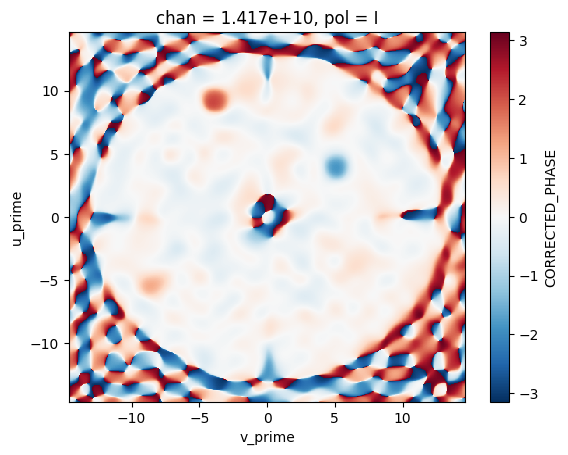

In [11]:
image_mds["ant_ea25"]["ddi_0"].CORRECTED_PHASE.isel(chan=0, pol=0).plot()

## Panel

The `panel` function takes the place of and expands the `PANEL` AIPS function to processes the image information and derives adjustements to the dish panels. This produces a file on disk of format `.panel.zarr` containing information on corrections, residuals and screw adjustments. As an added bonus the `panel` function has a helper function to convert aips data to astrohack format and process it using the `aips_holog_to_astrohack` function. For a full description of the operation and arguments of the `panel` function see [docs](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/panel/index.html).

In [12]:
from astrohack.panel import panel

panel_model = "rigid"

panel_mds = panel(
    image_name="data/ea25_cal_small_after_fixed.split.image.zarr",
    panel_model=panel_model,
    panel_margins=0.2,
    clip_type="relative",
    clip_level=0.2,
    parallel=True,
    overwrite=True,
)

[2025-10-29 14:59:15,740]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


[2025-10-29 14:59:15,747]     INFO   astrohack:  Creating output file name: data/ea25_cal_small_after_fixed.split.panel.zarr 


[2025-10-29 14:59:16,120]     INFO    worker_1:  processing EA06: DDI 0 


[2025-10-29 14:59:16,424]     INFO    worker_2:  processing EA25: DDI 0 


[2025-10-29 14:59:17,269]     INFO    worker_3:  processing EA25: DDI 1 


[2025-10-29 14:59:18,186]     INFO    worker_0:  processing EA06: DDI 1 


[2025-10-29 14:59:19,006]  WARNING    worker_0:  EA06: DDI 1: Fit failed with the rigid model and a simple mean has been used instead for the following panels: 
[2025-10-29 14:59:19,006]  WARNING    worker_0:  ['6-10'] 


[2025-10-29 14:59:19,460]     INFO   astrohack:  Finished processing 


___panel_name.panel.zarr:___ <span style="color:red"> The panel zarr file contains process information regarding the per panel screw corrections as well as residuals, masks and phase corrections used to produce them. The panel file structure is a compound dictionary keyed according to `ant` -> `ddi` with the value consisting of the panel dataset.</span>

```
panel_mds = 
{
   ant_0:{
          ddi_0: panel_ds,
                 ⋮               
          ddi_m: panel_ds
         },
       ⋮
   ant_n: …

```

An example of the panel dataset object is show below.

In [13]:
panel_mds["ant_ea25"]["ddi_0"]

<xarray.Dataset> Size: 21MB
Dimensions:             (u: 510, v: 510, labels: 172, pars: 3, screws: 4)
Coordinates:
  * labels              (labels) object 1kB '1-1' '1-2' '1-3' ... '6-39' '6-40'
  * pars                (pars) int64 24B 0 1 2
  * screws              (screws) <U2 32B 'il' 'ir' 'ol' 'or'
  * u                   (u) float64 4kB 14.62 14.56 14.5 ... -14.5 -14.56 -14.62
  * v                   (v) float64 4kB -14.62 -14.56 -14.5 ... 14.5 14.56 14.62
Data variables: (12/15)
    AMPLITUDE           (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
    AMP_NOISE           (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
    CORRECTIONS         (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
    DEVIATION           (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
    MASK                (u, v) bool 260kB dask.array<chunksize=(255, 510), meta=np.ndarray>
    PANEL_DISTRIBUTION  (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
    ...                  ...
    PANEL_SCREWS        (labels, screws) float64 6kB dask.array<chunksize=(172, 4), meta=np.ndarray>
    PHASE               (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
    PHASE_CORRECTIONS   (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
    PHASE_RESIDUALS     (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
    RADIUS              (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
    RESIDUALS           (u, v) float64 2MB dask.array<chunksize=(128, 255), meta=np.ndarray>
Attributes: (12/16)
    amp_unit:             V
    aperture_resolution:  [1.4366515837104072, 1.4366515837104072]
    clip:                 0.5412720936531105
    ddi:                  ddi_0
    fitted:               True
    input_gain:           41.57934084050393
    ...                   ...
    panel_model:          rigid
    pol_state:            I
    solved:               True
    summary:              {'aperture': {'cell size': [-0.05744485294117574, 0...
    theoretical_gain:     41.71607063670329
    wavelength:           0.021161322651231735

A summary of the available key values can be obtained using the summary convenience function. Additionally a final summary of the observation characteristics can be accessed through the observation_summary method.

In [14]:
panel_mds.summary()
print(f"\n\n{100*'*'}\n\n")
panel_mds.observation_summary(
    "data/ea25_cal_small_after_fixed.split.panel.zarr.summary.txt"
)

####################################################################################################
###                                         Summary for:                                         ###
###                       data/ea25_cal_small_after_fixed.split.panel.zarr                       ###
####################################################################################################

Full documentation for AstrohackPanelFile objects' API at: 
https://astrohack.readthedocs.io/en/stable/_api/autoapi/astrohack/mds/index.html#astrohack.mds.AstrohackPanelFile

Input Parameters:
+--------------------+--------------------------------------------------+
| Parameter          | Value                                            |
+--------------------+--------------------------------------------------+
| image_name         | data/ea25_cal_small_after_fixed.split.image.zarr |
| panel_name         | data/ea25_cal_small_after_fixed.split.panel.zarr |
| clip_type          | relative 

############################################################
###                   ant_ea06, ddi_1                    ###
############################################################

   General:
      Telescope name     => EVLA
      Antenna name       => ea06
      Station            => N04
      Reference antennas => ['ea04 @ E03']
      Source             => HOLORASTER
      Phase center       => 22h53m57.748s +16°08m53.561s [FK5]
      Az el info         => @ l,m = (0,0), Az, El = (101.8, 45.6) [deg]
      Start time         => 20 Sep 2022, 01:19:00 (UTC)
      Stop time          => 20 Sep 2022, 04:29:47 (UTC)
      Duration           => 3 hour, 10 min, 47.00 sec

   Spectral:
      Channel width      => 114.000 MHz
      Frequency range    => 15.903 GHz to 16.017 GHz
      Number of channels => 1
      Rep. frequency     => 15.960 GHz
      Rep. wavelength    => 1.878 cm

   Beam:
      Cell size          => -2.20 amin by 2.20 amin
      Grid size          => 31 by 31 pixels
    

## Additional Functions

The `panel_mds` object provides two helper functions for the user to export or investigate the results of the `panel` function.
- `export_screws()`: This method exports the screw and panel adjustements from the panel output file.
- `plot_antennas()`: This method plots one of three diagnostics plots from the panel output file data. The plots types are: deviation, phase and ancillary.

Examples usage for each helper functions are given below and more detailed documentation can be found in the [visualization tutorial](https://astrohack.readthedocs.io/en/latest/visualization_tutorial.html).

[2025-10-29 14:59:19,692]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


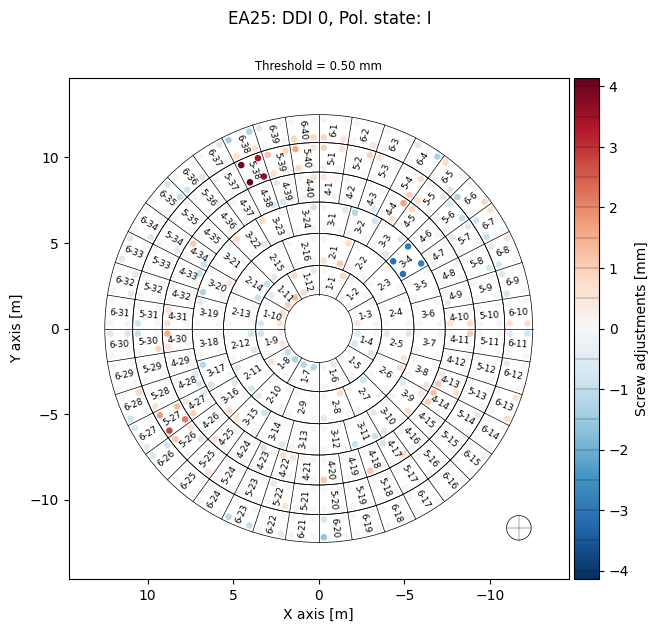

In [15]:
export_folder = "exports"

panel_mds.export_screws(
    destination=export_folder,
    ant="ea25",
    ddi=0,
    unit="mm",
    threshold=0.5,  # Threshold in mm for significant adjustments
    display=True,
)

In [16]:
with open(export_folder + "/panel_screws_ant_ea25_ddi_0.txt", "r") as file:
    for _ in range(30):
        print(file.readline()[:-1])

# Screw adjustments for VLA's EA25: DDI 0, pol. state I
# Frequency = 14.1670 GHz
# Antenna surface RMS before adjustment: 0.50 mm
# Antenna surface RMS after adjustment: 0.22 mm
# Lower means away from subreflector
# Raise means toward the subreflector
# LOWER the panel if the number is POSITIVE
# RAISE the panel if the number is NEGATIVE
# Adjustments are in mm

# Panel      il        ir        ol        or    Fallback    Model
  1-1     -0.26      0.13      0.16      0.89      no       rigid
  1-2     -0.25     -0.44      0.42      0.06      no       rigid
  1-3      0.43      0.52      0.03      0.20      no       rigid
  1-4     -0.53     -0.74     -0.33     -0.71      no       rigid
  1-5     -0.41     -0.28     -0.39     -0.16      no       rigid
  1-6     -0.52     -0.35     -0.06      0.26      no       rigid
  1-7     -1.19     -1.21      0.32      0.28      no       rigid
  1-8     -1.28     -1.01      0.16      0.67      no       rigid
  1-9      0.54      0.09      0.03   

[2025-10-29 14:59:23,190]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


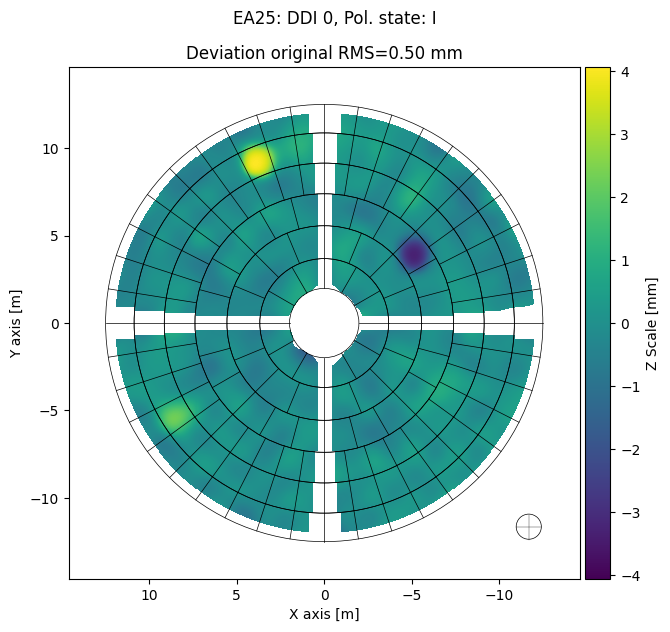

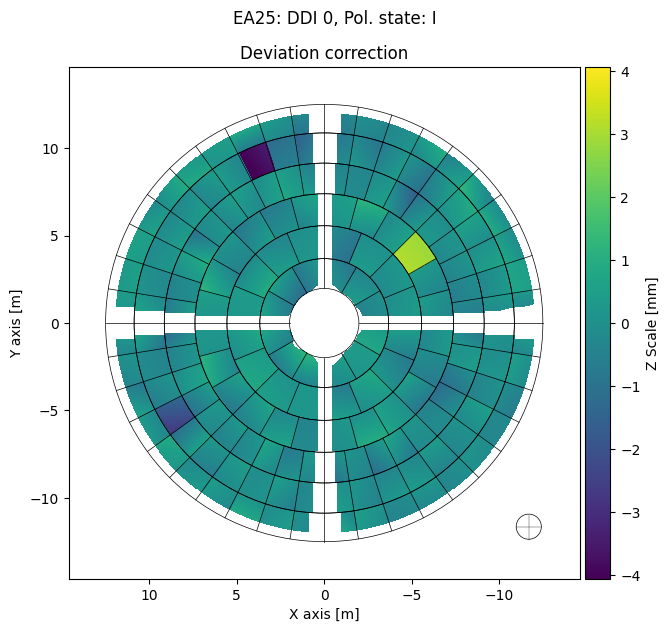

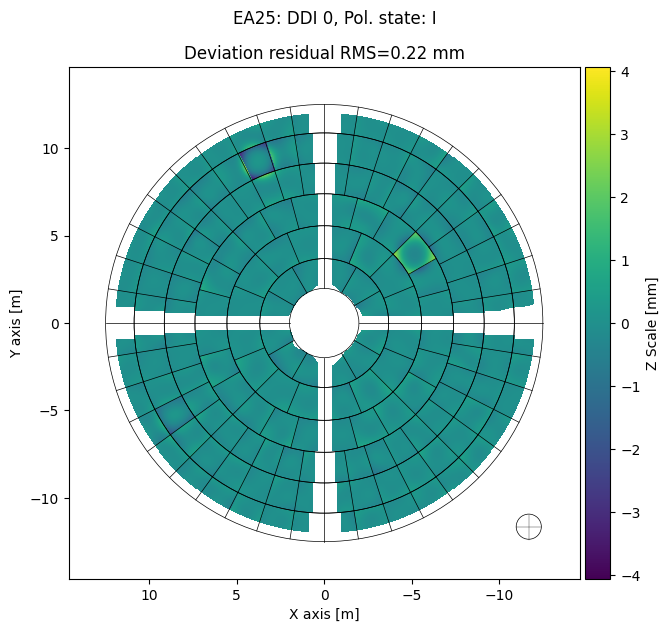

In [17]:
panel_mds.plot_antennas(
    destination=export_folder,
    ant="ea25",
    ddi=0,
    plot_type="deviation",
    plot_screws=False,
    dpi=300,
    parallel=False,
    display=True,
)